In [1]:
import boto3
import io
from datetime import datetime, timezone
import pandas as pd
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import ast
import shapefile
import matplotlib.pyplot as plt
import seaborn as sns


today = datetime.now(timezone.utc)
client = boto3.client(
    's3',
    aws_access_key_id='#########################',
    aws_secret_access_key='##########################',
    
)

#create a bucket
#client.create_bucket(Bucket = 'car-crashes-bucket')

# see the list of current buckets

bucket_list = client.list_buckets()

bucket_names = [bucket['Name'] for bucket in bucket_list['Buckets']]

bucket_names

#how to extract data from the buckets

objects = client.list_objects(Bucket= 'corona-experiments')

file_dict = {}
file_names = []
file_times = []
for o in objects["Contents"]:
    file_names.append(o["Key"])
    file_times.append(o["LastModified"])
        #file_dict.update(dict(item = o["Key"],time = o["LastModified"]))
        #print(dict(item = o["Key"],time = o["LastModified"]))
file_dict.update(dict(file_name = file_names,last_modified = file_times))

file_df = pd.DataFrame(file_dict)

#this allows me to get only those objects that are in the data/nys directory and contain _v2 in file name
# I have restricted the selection to the latest covid data from the nys data source
##### nys data
nys_infections = file_df[(file_df['file_name'].str.contains('data/nys/')) & (file_df['file_name'].str.contains('_v2'))]
nys_infections['last_modified'] = pd.to_datetime(nys_infections['last_modified'])
nys_infections_latest_file = nys_infections[nys_infections['last_modified'] == nys_infections['last_modified'].max()]

In [50]:
#this gives me the geodata for all us zip codes. the sources is the us census bureau 

fp = '~/data/tl_2018_us_zcta510/tl_2018_us_zcta510.shp'
#map_df = gpd.read_file(fp)
counties_usa_shape = gpd.read_file(fp)
counties_usa_shape.columns = counties_usa_shape.columns.str.lower()

counties_usa_shape.head()

# the latest nyc data by zip code
# the source is the nyc doh
cases_nyc_zip = pd.read_csv('https://raw.githubusercontent.com/nychealth/coronavirus-data/master/tests-by-zcta.csv')
cases_nyc_zip = cases_nyc_zip[~cases_nyc_zip['MODZCTA'].isnull()]
cases_nyc_zip['date'] = pd.to_datetime('today').date()

cases_nyc_zip.head()

#removing the null zipcodes
cases_nyc_zip = cases_nyc_zip[~cases_nyc_zip['MODZCTA'].isnull()]
nyc_zip_list = list(cases_nyc_zip['MODZCTA'])

# this gives me the geo data for the nyc counties that have been affected by covid
counties_usa_shape['zcta5ce10'] = counties_usa_shape['zcta5ce10'].astype('float')
nyc_counties_geodata = counties_usa_shape[counties_usa_shape['zcta5ce10'].isin(nyc_zip_list)]

# adding the covid info to the geo data
map_zip = pd.merge(nyc_counties_geodata,cases_nyc_zip, how ='left', left_on = 'zcta5ce10', right_on = 'MODZCTA')
map_zip.head()



# source : the us census bureau
household_income = pd.read_csv('~/data/ACSST5Y2018.S1901_data_with_overlays_2020-04-02T191540.csv')

household_income = household_income[['GEO_ID','NAME','S1901_C01_001E','S1901_C01_013E']]
household_income['NAME'] = household_income['NAME'].str.extract('(\d{5})')
household_income.rename(columns ={'GEO_ID':'geo_id','NAME':'zip_code','S1901_C01_013E':'household_mean_income','S1901_C01_001E':'household_number'}, inplace = True)
#I changed the zip to float to match the the datatype in the geo dataframe. It might be better to have zip as string, eventhough I do not thing that any info is lost
# by changing it to float
household_income['zip_code'] = household_income['zip_code'].astype('float')
household_income.head()

# getting the household income  from only nyc zip codes 
nyc_household_income= household_income[household_income['zip_code'] .isin(nyc_zip_list)]
nyc_household_income.head()

# i added the income info to the geo data
map_zip_2 = pd.merge(map_zip,nyc_household_income, how ='left', left_on = 'zcta5ce10', right_on = 'zip_code')

map_zip_2.drop(columns = ['geoid10','MODZCTA','Total','zcta_cum.perc_pos','zip_code'], axis = 1, inplace = True)
map_zip_2.head()

,zcta5ce10,classfp10,mtfcc10,funcstat10,aland10,awater10,intptlat10,intptlon10,geometry,Positive,date,geo_id,household_number,household_mean_income
0,10065.0,B5,G6350,S,984659,0,+40.7646284,-073.9631438,"POLYGON ((-73.97210 40.76552, -73.97165 40.766...",166,2020-04-05,8600000US10065,14844,242978
1,10069.0,B5,G6350,S,249044,0,+40.7759598,-073.9903411,"POLYGON ((-73.99597 40.77401, -73.99397 40.773...",29,2020-04-05,8600000US10069,2552,225183
2,10075.0,B5,G6350,S,477128,0,+40.7733631,-073.9562218,"POLYGON ((-73.96469 40.77568, -73.96423 40.776...",195,2020-04-05,8600000US10075,11035,233358
3,10128.0,B5,G6350,S,1206193,0,+40.7814283,-073.9500104,"MULTIPOLYGON (((-73.93951 40.77922, -73.93957 ...",275,2020-04-05,8600000US10128,30691,196844
4,10280.0,B5,G6350,S,297265,38397,+40.7090731,-074.0164230,"POLYGON ((-74.01960 40.70564, -74.01955 40.706...",19,2020-04-05,8600000US10280,4560,224631


In [51]:
#################################################################################### data sets
##### nys numbers
key = list(nys_infections_latest_file['file_name'])[0]
obj = client.get_object(Bucket='corona-experiments', Key= key)
data = obj['Body'].read()
infections_nys_county_all_time = pd.read_csv(io.BytesIO(data), encoding='utf-8')
# 03/18/2020 had a lot of missing data that is why I am removing it
infections_nys_county_all_time = infections_nys_county_all_time[infections_nys_county_all_time['test_date'] != '2020-03-18']
#####
infections_nys_county_latest = infections_nys_county_all_time[infections_nys_county_all_time['test_date'] == infections_nys_county_all_time['test_date'].max()]
infections_nys_county_latest.head()

#### nyc numbers by county
nyc = ['Bronx','Kings','Richmond','Queens','New York']

infections_nyc_all_time = infections_nys_county_all_time[infections_nys_county_all_time['county'].isin(nyc)]

infections_nyc_latest = infections_nyc_all_time[infections_nyc_all_time['test_date'] == infections_nyc_all_time['test_date'].max()]

infections_nyc_latest

infections_nyc_all_time_sum = infections_nyc_all_time.groupby(['test_date'], as_index = False).sum()
infections_nyc_all_time_sum.head()

,test_date,Unnamed: 0,new_positives,cumulative_number_of_positives,total_number_of_tests,cumulative_number_of_tests
0,2020-03-19,4787,1937,4408,4844,14385
1,2020-03-20,4477,1805,6213,5077,19462
2,2020-03-21,4167,2832,9045,6927,26389
3,2020-03-22,3857,3260,12305,6614,33003
4,2020-03-23,3547,2599,14904,5387,38390


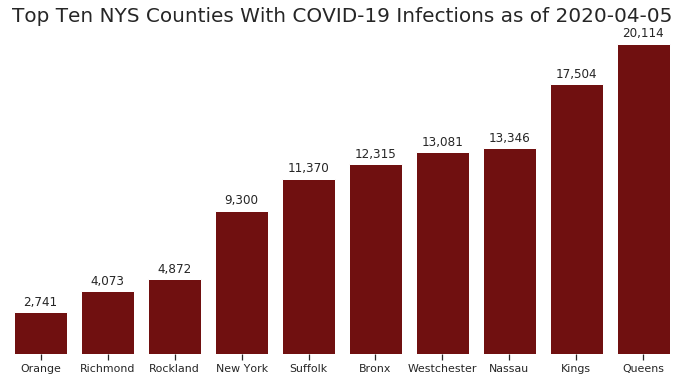

In [52]:
today = pd.to_datetime('today').date()
top_ten_counties = infections_nys_county_latest.sort_values('cumulative_number_of_positives', ascending = False).head(10)

top_ten_counties = top_ten_counties.sort_values('cumulative_number_of_positives', ascending = True)

plt.figure(figsize = (12,6))

ax = sns.barplot(x = top_ten_counties['county'], y = top_ten_counties['cumulative_number_of_positives'], color = 'maroon')

plt.title(f'Top Ten NYS Counties With COVID-19 Infections as of {today}', fontsize = 20)

plt.xlabel('')
plt.ylabel('')

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.get_yaxis().set_ticks([])

# these get rid of the borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
    

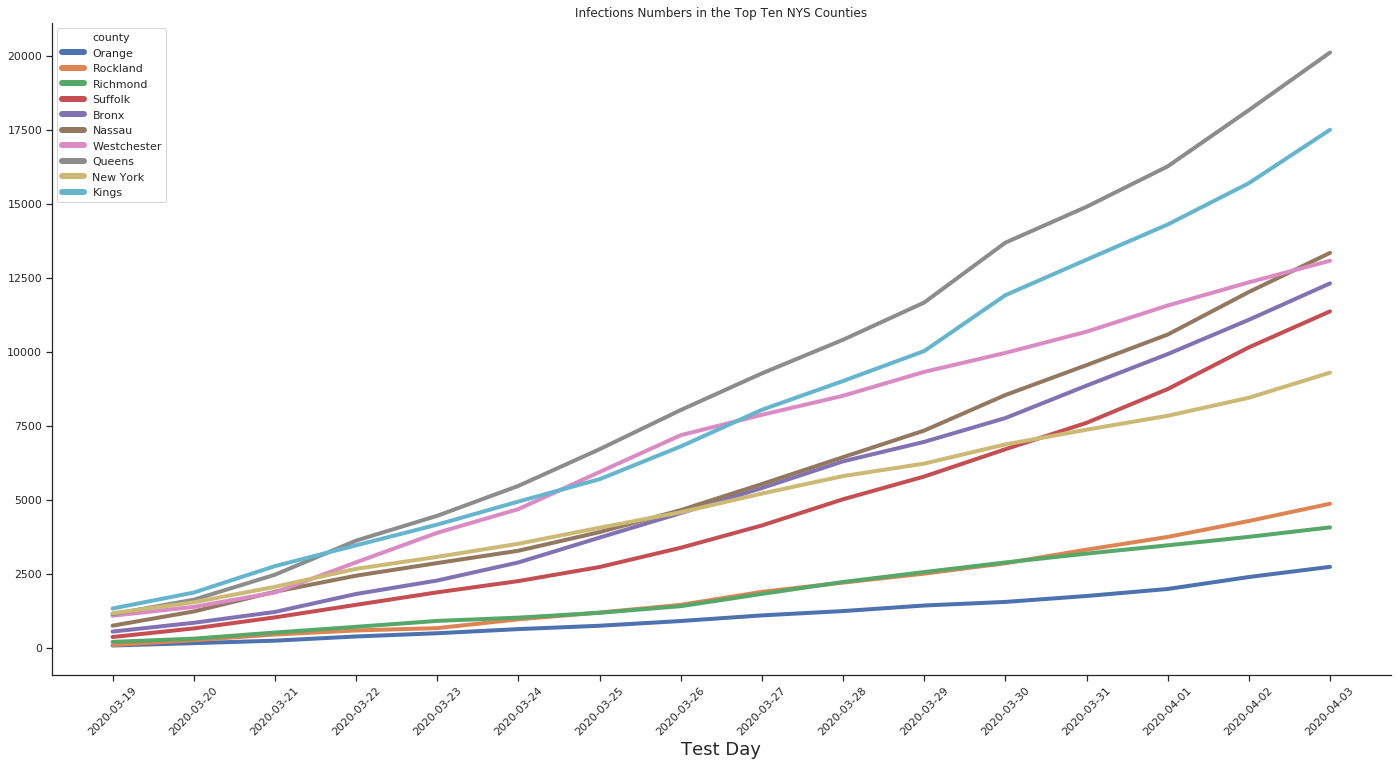

In [53]:
#top ten over time

top_ten_alltime = infections_nys_county_all_time[infections_nys_county_all_time['county'].isin(list(top_ten_counties['county']))]
top_ten_alltime.sort_values(by = 'cumulative_number_of_positives', inplace = True)
plt.figure(figsize = (24,12))

sns.set(style="ticks", rc={"lines.linewidth": 4})

ax = sns.lineplot(x="test_date", y="cumulative_number_of_positives",

                     hue="county", 

                     data= top_ten_alltime)


# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.title('Infections Numbers in the Top Ten NYS Counties')
plt.xticks(rotation = 45)
plt.xlabel('Test Day', fontsize = 18)
plt.ylabel('', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax

No handles with labels found to put in legend.
No handles with labels found to put in legend.


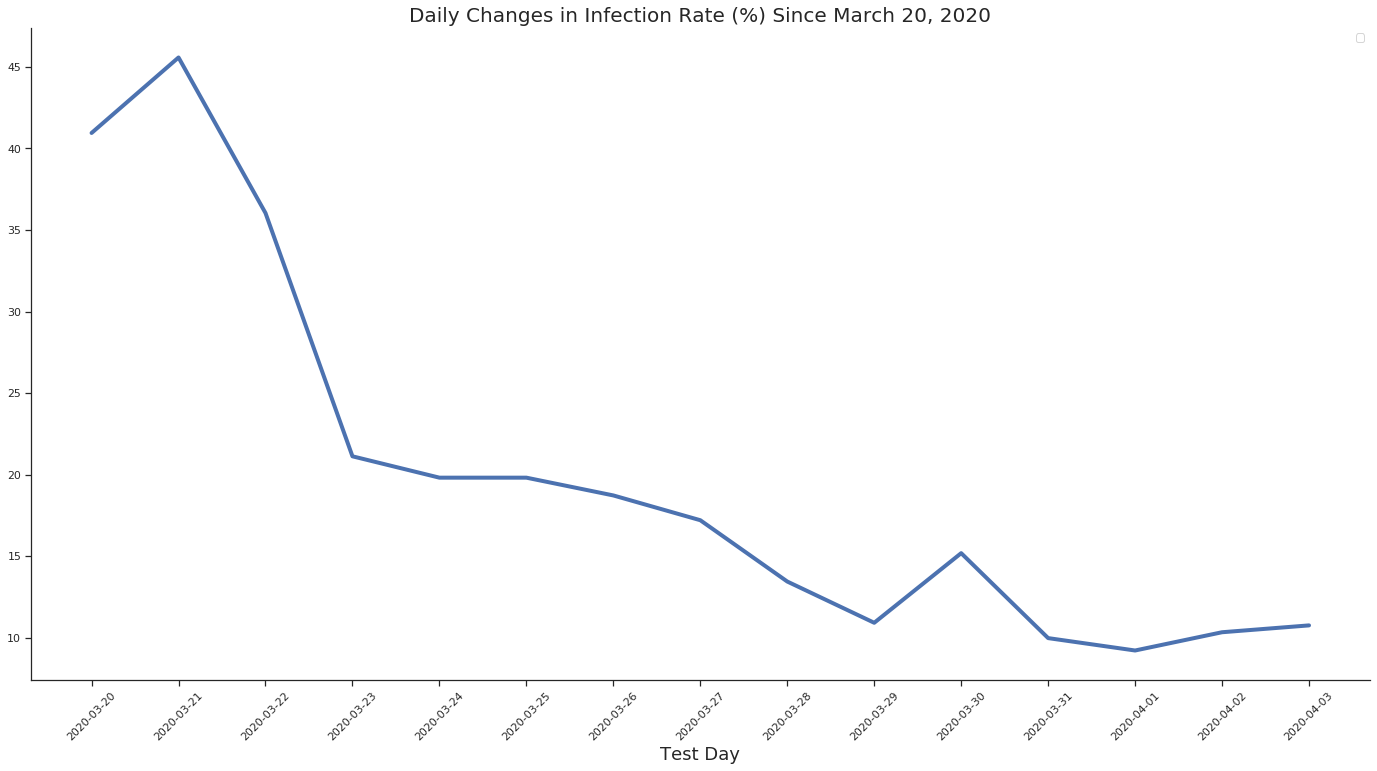

In [54]:
############################################################################### changes in infection rate ###########################################################################################
infections_nyc_all_time_sum['percent_change_positives'] = round((infections_nyc_all_time_sum['cumulative_number_of_positives'].pct_change()) *100,2)

top_ten_alltime.sort_values(by = 'cumulative_number_of_positives', inplace = True)
plt.figure(figsize = (24,12))

sns.set(style="ticks", rc={"lines.linewidth": 4})

ax = sns.lineplot(x="test_date", y="percent_change_positives",

                     data= infections_nyc_all_time_sum)


# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.title('Daily Changes in Infection Rate (%) Since March 20, 2020', fontsize = 20)
plt.xticks(rotation = 45)
plt.xlabel('Test Day', fontsize = 18)
plt.ylabel('', fontsize = 18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax

No handles with labels found to put in legend.
No handles with labels found to put in legend.


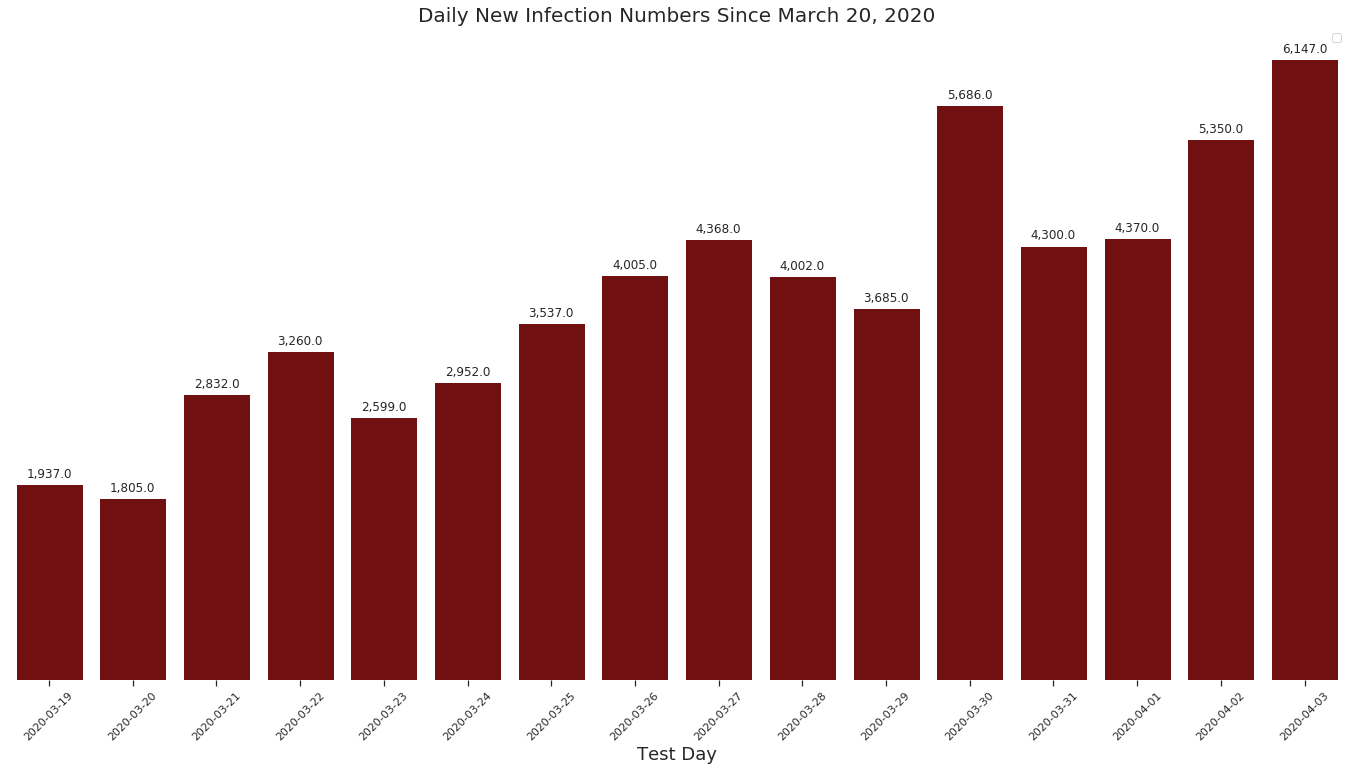

In [55]:
top_ten_alltime.sort_values(by = 'cumulative_number_of_positives', inplace = True)
plt.figure(figsize = (24,12))

sns.set(style="ticks", rc={"lines.linewidth": 4})

ax = sns.barplot(x="test_date", y="new_positives",

                     data= infections_nyc_all_time_sum,
                color = 'maroon')


# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 20)

leg = ax.legend()

for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.title('Daily New Infection Numbers Since March 20, 2020', fontsize = 20)
plt.xticks(rotation = 45)
plt.xlabel('Test Day', fontsize = 18)
plt.ylabel('', fontsize = 18)

ax.get_yaxis().set_ticks([])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# the ',' in format adds the commas. COOL feature
for p in ax.patches:
    ax.annotate(format(p.get_height(),','), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
ax

In [63]:
# this creates the coordinates where I am going to place the zip text
map_zip_2['coords'] = map_zip_2['geometry'].apply(lambda x: x.centroid.coords[:])
map_zip_2['coords'] = [coords[0] for coords in map_zip_2['coords']]
map_zip_2.head()

,zcta5ce10,classfp10,mtfcc10,funcstat10,aland10,awater10,intptlat10,intptlon10,geometry,Positive,date,geo_id,household_number,household_mean_income,coords
0,10065.0,B5,G6350,S,984659,0,+40.7646284,-073.9631438,"POLYGON ((-73.97210 40.76552, -73.97165 40.766...",166,2020-04-05,8600000US10065,14844,242978,"(-73.96314399728709, 40.76462843802215)"
1,10069.0,B5,G6350,S,249044,0,+40.7759598,-073.9903411,"POLYGON ((-73.99597 40.77401, -73.99397 40.773...",29,2020-04-05,8600000US10069,2552,225183,"(-73.99034099626427, 40.77595988322896)"
2,10075.0,B5,G6350,S,477128,0,+40.7733631,-073.9562218,"POLYGON ((-73.96469 40.77568, -73.96423 40.776...",195,2020-04-05,8600000US10075,11035,233358,"(-73.95622207958226, 40.77336302749882)"
3,10128.0,B5,G6350,S,1206193,0,+40.7814283,-073.9500104,"MULTIPOLYGON (((-73.93951 40.77922, -73.93957 ...",275,2020-04-05,8600000US10128,30691,196844,"(-73.9500106407624, 40.781428316755665)"
4,10280.0,B5,G6350,S,297265,38397,+40.7090731,-074.0164230,"POLYGON ((-74.01960 40.70564, -74.01955 40.706...",19,2020-04-05,8600000US10280,4560,224631,"(-74.01685739817792, 40.70917914705205)"


Text(0.5, 1.0, 'Corona Infections by Zip Code, NYC')

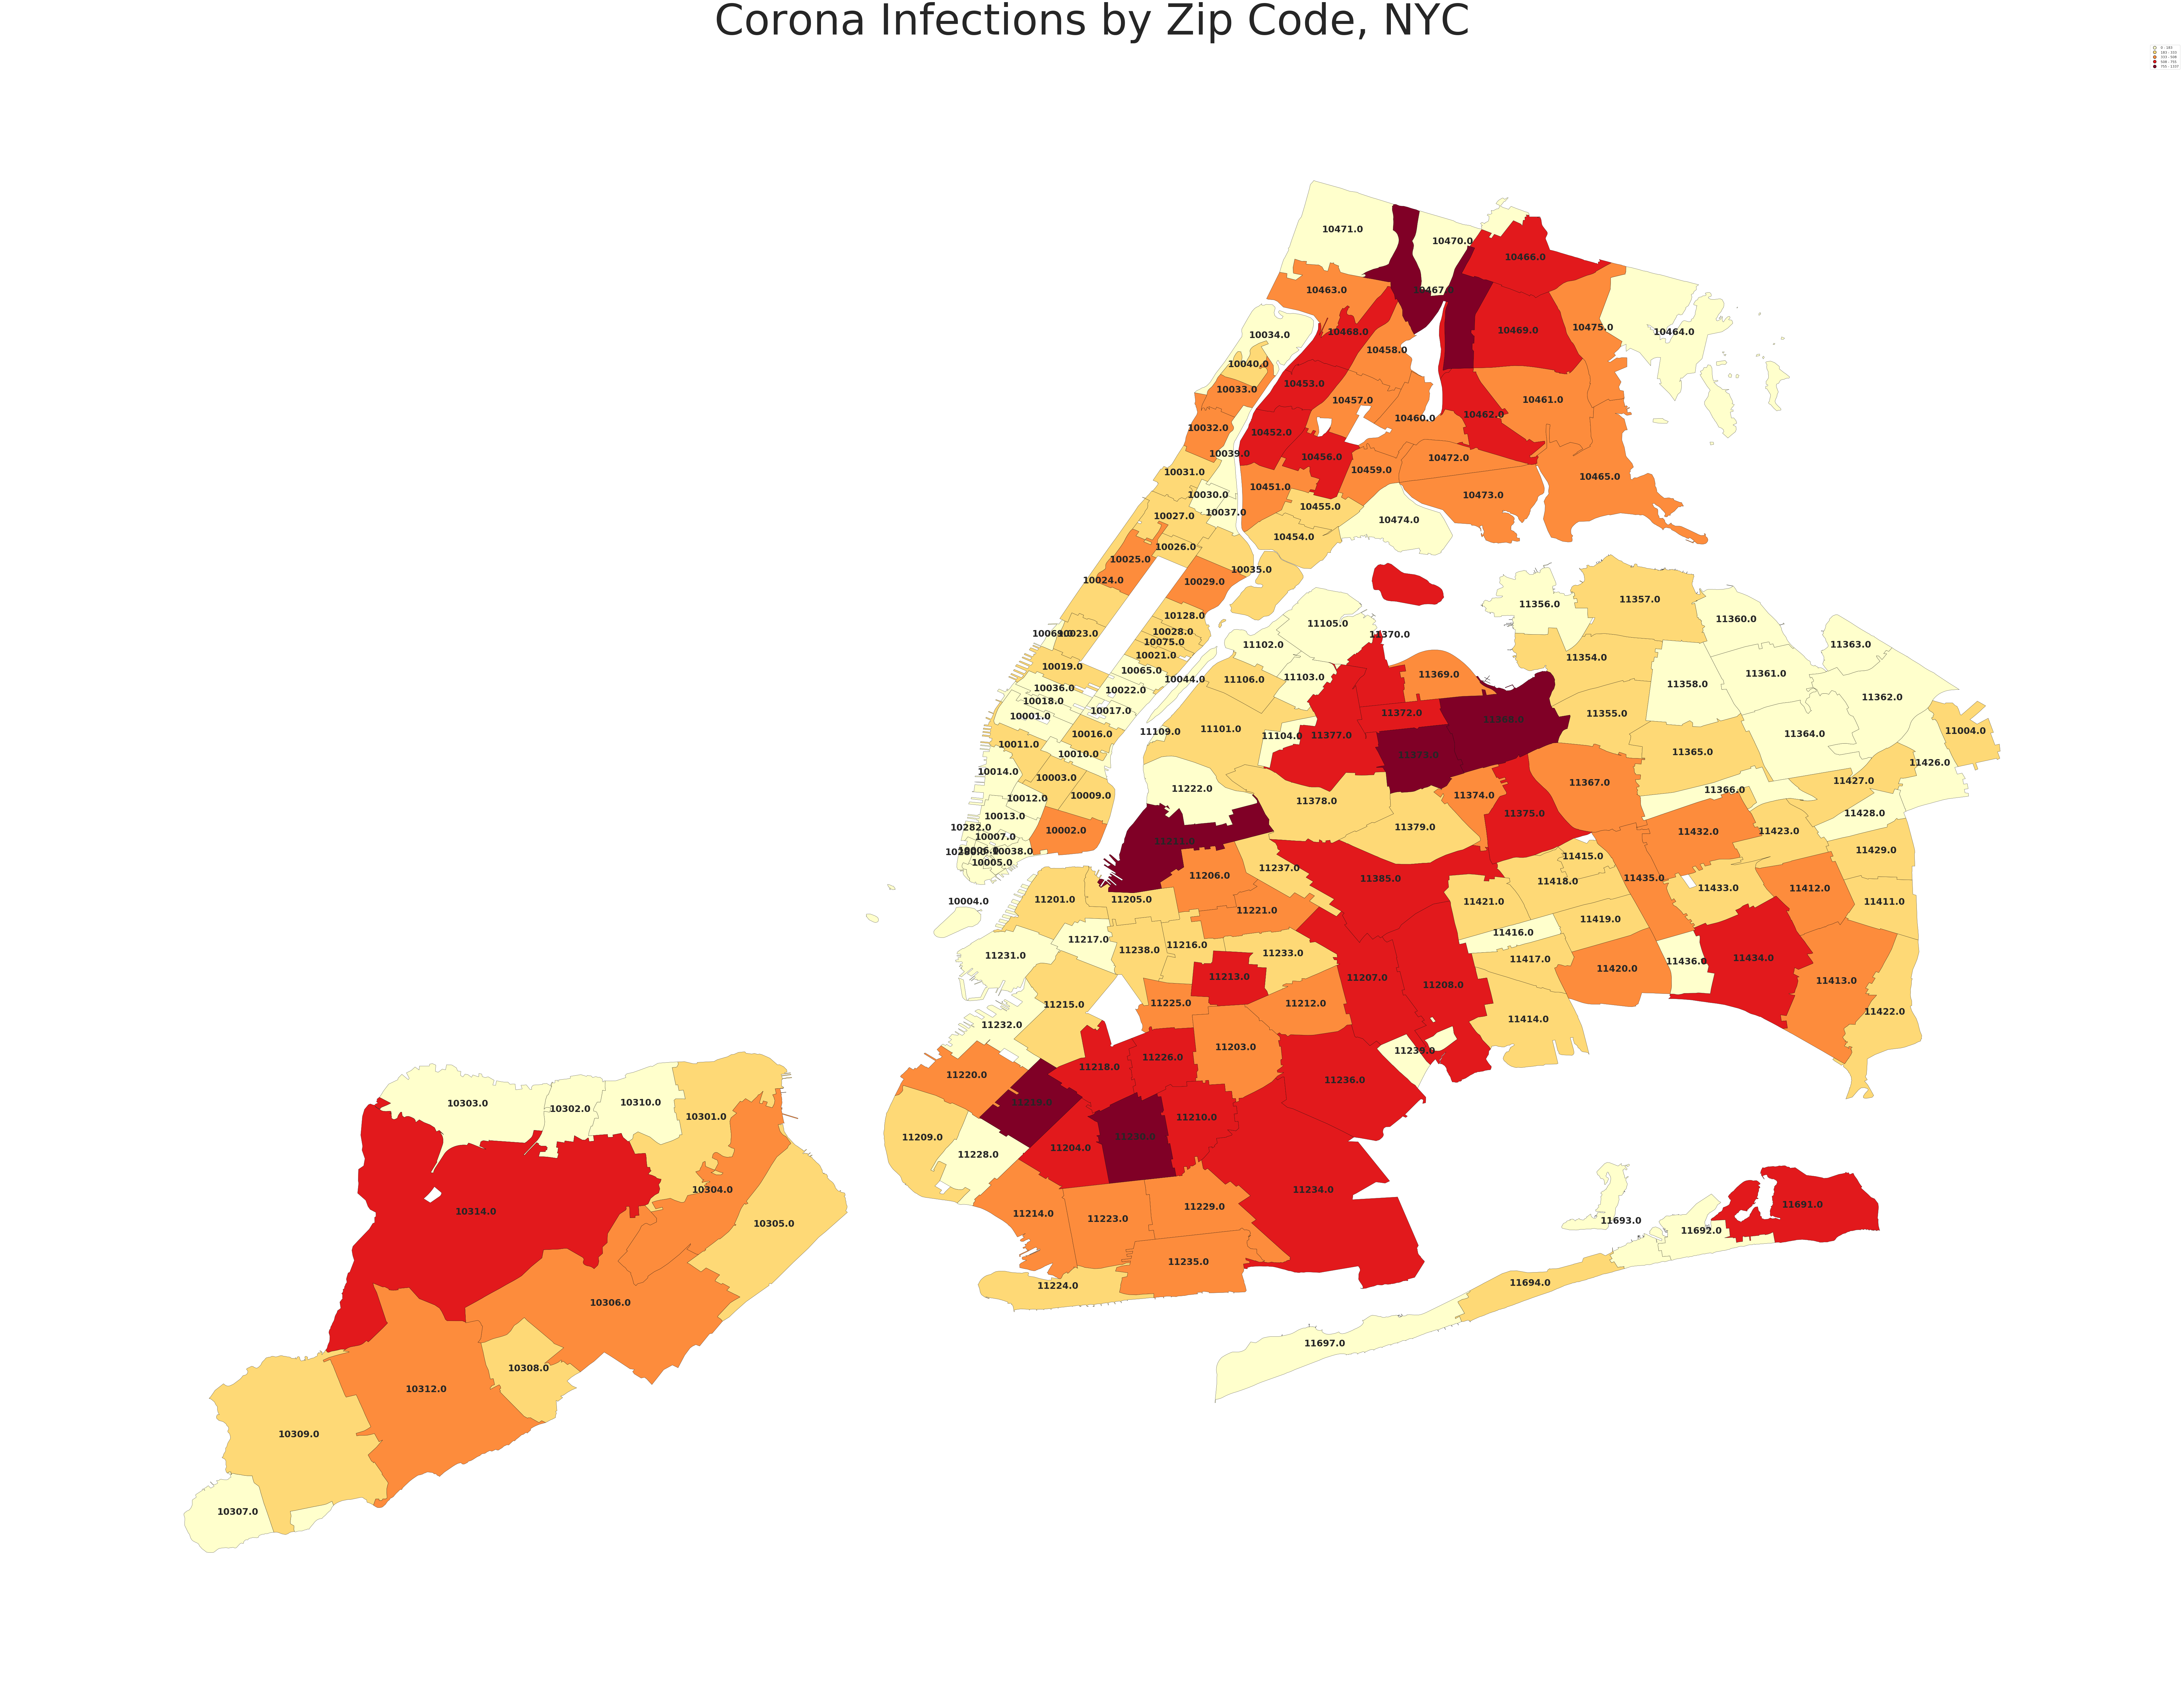

In [160]:

gplt.choropleth(
    map_zip_2, hue='Positive', 
    edgecolor='black', linewidth=0.5,
    cmap='YlOrRd', legend = True,
    scheme='FisherJenks',
    figsize = (130,100))


for _, row in map_zip_2.iterrows():
    hue = map_zip_2['Positive']
    plt.text(x = row['coords'][0], y = row['coords'][1],s =row['zcta5ce10'],
        horizontalalignment='center', 
        fontdict = {'weight': 'bold', 'size': 30})

    

plt.title("Corona Infections by Zip Code, NYC", fontsize = 140)


# I still need to fix the legend issue